In [1]:
%matplotlib notebook


Advanced example: querying the literature with brain maps
=========================================================

In this example, instead of providing a text query to find related brain
regions, we provide a brain map and discover which terms or studies in the
literature are associated with similar activation patterns.


In [2]:
import pathlib

import numpy as np
import pandas as pd
from joblib import Memory
from matplotlib import pyplot as plt

from nilearn import plotting
from nilearn.datasets import fetch_localizer_contrasts

from neuroquery import datasets
from neuroquery.img_utils import coordinates_to_maps, gaussian_coord_smoothing
from neuroquery.encoding import NeuroQueryModel

Finding terms with similar activations
======================================



Load model and compute maps for all terms
-----------------------------------------
We cache the computed maps to save time when running this script again



In [3]:
# You can set the cache directory to a different location
cache_directory = pathlib.Path("cache")
cache_directory.mkdir(parents=True, exist_ok=True)
maps_file = cache_directory / "masked_term_maps.npy"

encoder = NeuroQueryModel.from_data_dir(datasets.fetch_neuroquery_model())
voc = np.asarray(encoder.full_vocabulary())
if maps_file.is_file():
    term_maps = np.load(str(maps_file))
else:
    print("Computing brain maps for all terms in the vocabulary...")
    term_maps = encoder.get_masker().transform(
        encoder.transform(voc[:, None])["brain_map"]
    )
    print("Done")
    np.save(str(maps_file), term_maps)

Obtain some example brain maps
------------------------------
We load example subject-level tmaps from a localizer dataset, and also
generate a brain maps from a set of MNI coordinates.



In [4]:
queries = {}

contrasts = ["left vs right button press", "sentence listening"]

for contrast in contrasts:
    query_map = fetch_localizer_contrasts(
        [contrast], n_subjects=1, get_tmaps=True
    )["tmaps"][0]
    queries[contrast] = query_map

dmn_coords = [(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)]
dmn_img = gaussian_coord_smoothing(dmn_coords, encoder.get_masker())
masked_dmn = encoder.get_masker().transform(dmn_img).ravel()
queries["DMN coordinates"] = dmn_img

/home/jerome/.virtualenvs/py3.7/lib/python3.7/site-packages/numpy/lib/npyio.py:2322: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


Discover which terms have activations similar to the query map
--------------------------------------------------------------
Here we simply use the dot product with the absolute values of the input map



<IPython.core.display.Javascript object>


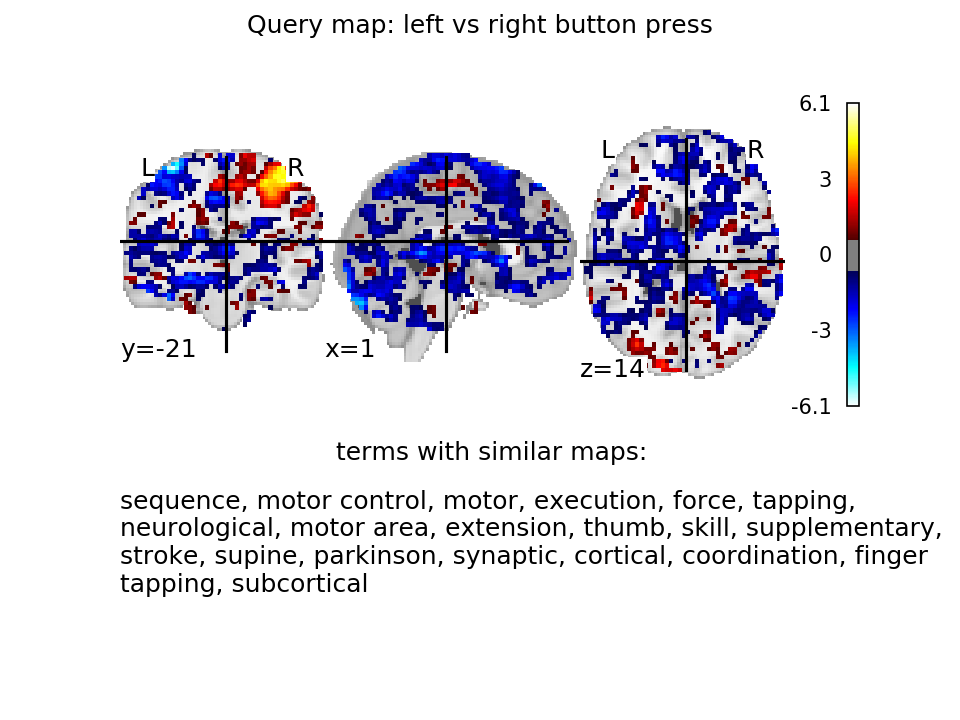

<IPython.core.display.Javascript object>


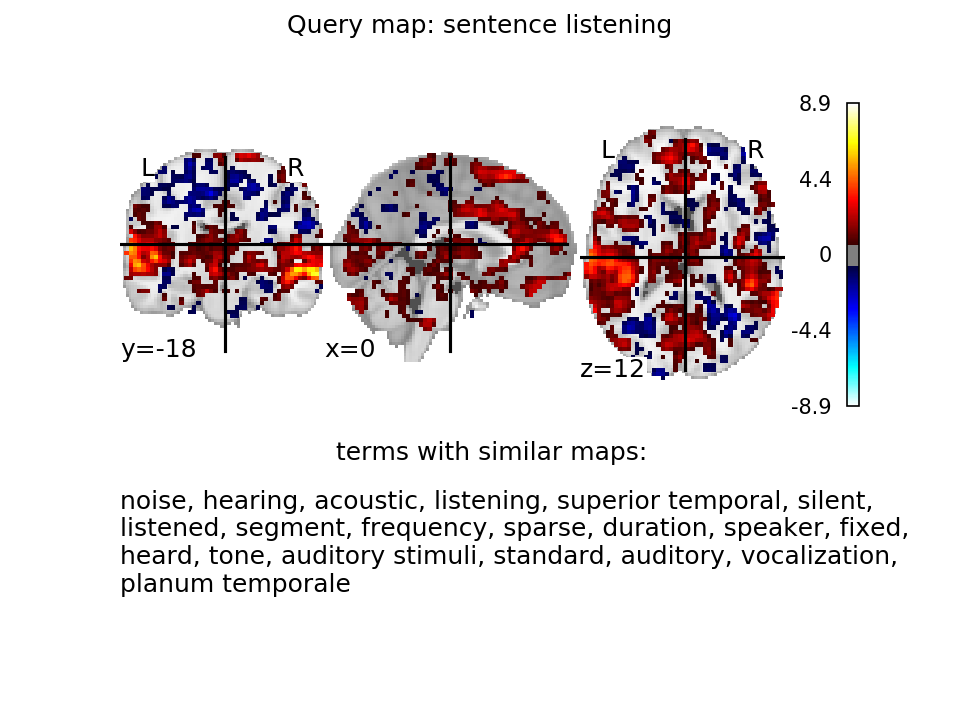

<IPython.core.display.Javascript object>


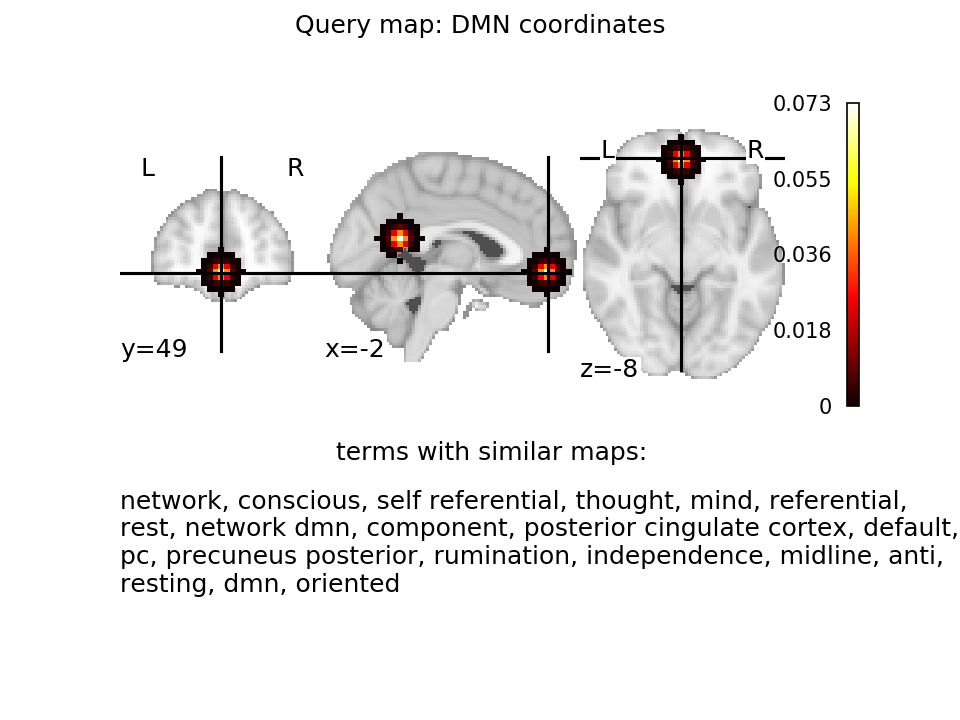

In [5]:
for name, query_map in queries.items():
    masked_query = encoder.get_masker().transform(query_map).ravel()
    similarities = np.abs(masked_query).dot(term_maps.T)
    # rescale by document frequencies, optional
    similarities *= np.log(1 + encoder.document_frequencies().values.ravel())
    top_20 = np.argsort(similarities)[::-1][:20]
    top_terms = voc[top_20].ravel()

    fig, (map_ax, text_ax) = plt.subplots(
        2, 1, gridspec_kw={"height_ratios": [1.0, 0.5]}
    )
    text = ", ".join(list(top_terms))
    plotting.plot_stat_map(query_map, axes=map_ax, threshold="auto")
    fig.suptitle("Query map: {}".format(name))
    text_ax.set_title("terms with similar maps:")
    text_ax.text(0, 0.9, text, va="top", ha="left", wrap=True, fontsize=12)
    text_ax.set_axis_off()

plt.show()

Finding studies with similar activations
========================================



Transform the coordinates into brain maps
-----------------------------------------
Here we generate brain maps for all the studies in the NeuroQuery dataset,
using the activation coordinates. This takes a long time(around 15mn) so we
cache the result.



In [6]:
corpus_metadata = encoder.corpus_info["metadata"].set_index("pmid")
coordinates = pd.read_csv(datasets.fetch_peak_coordinates())

# We cache the `coordinates_to_maps` function with joblib to avoid recomputing
# this if we train a new model.
coord_to_maps = Memory(str(cache_directory)).cache(coordinates_to_maps)

# You can set target_affine to a different value to increase image resolution
# or reduce computation time. The model on neuroquery.org uses 4 mm
# resolution i.e. target_affine=(4, 4, 4)
# You can also adjust the smoothing by setting `fwhm` (Full Width at Half
# maximum)
brain_maps, masker = coord_to_maps(
    coordinates, target_affine=(6, 6, 6), fwhm=9.0
)
brain_maps = brain_maps[(brain_maps.values != 0).any(axis=1)]
brain_maps /= np.sum(brain_maps.values, axis=1, keepdims=True)

Find studies with activations similar to the input maps
-------------------------------------------------------



In [7]:
for name, query_map in queries.items():
    masked_query = masker.transform(query_map).ravel()
    similarities = np.abs(masked_query).dot(brain_maps.values.T)
    top_studies = np.argsort(similarities)[::-1][:10]
    pmids = brain_maps.index.values[top_studies]
    pmids = [pmid for pmid in pmids if pmid in corpus_metadata.index]
    top_studies_info = corpus_metadata.loc[pmids, ["title"]]
    print(
        "\n\nMost similar studies to the brain map"
        " for {}:\n{:=<80}".format(name, "")
    )
    for pmid, title in top_studies_info.reset_index().values:
        print(pmid, title)



Most similar studies to the brain map for left vs right button press:
24416273 Contribution of the Resting-State Functional Connectivity of the Contralesional Primary Sensorimotor Cortex to Motor Recovery after Subcortical Stroke
19164537 Congenitally altered motor experience alters somatotopic organization of human primary motor cortex
16624582 Finger motion sensors for fMRI motor studies
18413350 Hemispheric Asymmetry of Frequency-Dependent Suppression in the Ipsilateral Primary Motor Cortex During Finger Movement: A Functional Magnetic Resonance Imaging Study
27079332 Abnormal degree centrality in Alzheimer's disease patients with depression: A resting-state functional magnetic resonance imaging study
20420884 To move or not to move: imperatives modulate action-related verb processing in the motor system
24416229 Effects of Combining 2 Weeks of Passive Sensory Stimulation with Active Hand Motor Training in Healthy Adults
24040262 Boosting BOLD fMRI by K-Space Density Weighted Echo